# Imports

In [1]:
import os
import sys
from typing import (
    Dict,
    List
)

import numpy as np
from numpy import ndarray

import pandas as pd
from pandas import DataFrame

from matplotlib import pyplot as plt

# Paths

In [2]:
NOTEBOOKS_PATH: str = os.getcwd()
SETTINGS_PATH: str = NOTEBOOKS_PATH.replace("notebooks", "settings")
QSRR_IC_PATH: str = os.path.dirname(NOTEBOOKS_PATH)

OPTIMIZATION_PATH: str = os.path.join(SETTINGS_PATH, "optimization.json")
SINGLE_TRAIN_PATH: str = os.path.join(SETTINGS_PATH, "single_train.json")

In [3]:
for path_ in {NOTEBOOKS_PATH, QSRR_IC_PATH, SETTINGS_PATH}:
    print(f"Path : {path_}")

Path : C:\Users\petar\PycharmProjects\QSRR_IC\settings
Path : C:\Users\petar\PycharmProjects\QSRR_IC
Path : C:\Users\petar\PycharmProjects\QSRR_IC\notebooks


In [4]:
if QSRR_IC_PATH not in sys.path:
    sys.path.append(QSRR_IC_PATH)

In [5]:
# Change the working dir to QSRR IC path
os.chdir(QSRR_IC_PATH)

# QSRR IC module imports

In [6]:
from qsrr_ic.analysis.srd import (
    SumOfRankingDifferences,
    SrdVisualizer
)
from qsrr_ic.analysis.srd.domain_models import SrdSettings
from qsrr_ic.config import (
    HyperParameterConfig,
    QsrrIcConfig
)
from qsrr_ic.enums import RegressorType
from qsrr_ic.load import (
    load_dataset,
    QsrrIcData,
    QsrrIcDataset
)
from qsrr_ic.models.iso2grad import Iso2Grad
from qsrr_ic.models.iso2grad.domain_models import Iso2GradData
from qsrr_ic.models.qsrr import QsrrModel
from qsrr_ic.models.qsrr.domain_models import QsrrData
from qsrr_ic.process import ProcessData
from qsrr_ic.runners import (
    QsrrIcModelRunner,    
    QsrrModelRunner
)

# Single Train

This example shows how to train models using the quantitative structure-retention relationships (QSRR) mode & isocratic to gradient (Iso2Grad) model APIs, estimate confidence intervals (CIs) of predictions and metrics using resampling with resplacement, and analyze the models using sum of ranking differences (SRD) / define the models' applicability domain (AD).

## Instantiate `QsrrIcConfig` object using the "single_train.json" example
- `QsrrIcConfig` is an object used to load all configs & settings
- Can be instantiated in three ways:
  * Using the constructor, takes individual config classes, as attributes
  * Using the factory method `QsrrIcConfig::from_dict()` which takes a dictionary of configs/settings
  * Using the method `QsrrIcConfig::from_json(filename="filename.json")` that loads a dictionary of config/settings & instantiates `QsrrIcConfig` using the factory method `QsrrIcConfig::from_dict()`

In [7]:
single_train_config: QsrrIcConfig = QsrrIcConfig.from_json(filename=SINGLE_TRAIN_PATH)

In [8]:
single_train_config.to_dict()

{'dataset': {'molecular_descriptors_for_qsrr_training_path': './datasets/qsrr_ic/2025-01-05-molecular_descriptors_for_qsrr_training.csv',
  'isocratic_retention_path': './datasets/qsrr_ic/2025-01-05-isocratic_retention.csv',
  'molecular_descriptors_for_iso2grad_path': './datasets/qsrr_ic/2025-01-05-molecular_descriptors_for_iso2grad.csv',
  'gradient_void_times_path': './datasets/qsrr_ic/2025-01-05-gradient_void_times.csv',
  'gradient_profiles_path': './datasets/qsrr_ic/2025-01-05-gradient_profiles.csv',
  'gradient_retention_path': './datasets/qsrr_ic/2025-01-05-gradient_retention.csv'},
 'training_type': 'single_train',
 'train_test_split': {'test_ratio': 0.7, 'random_seed': None, 'shuffle': True},
 'hyper_parameters': {'PLS': {'n_components': 4},
  'xGB': {'n_estimators': 497, 'learning_rate': 0.23, 'max_depth': 2},
  'GBR': {'n_estimators': 485, 'learning_rate': 0.23, 'max_depth': 2},
  'RFR': {'n_estimators': 150, 'max_depth': 15, 'min_samples_leaf': 1},
  'ADA': {'n_estimators'

## Load & Prepare Data

In [9]:
# Load the dataset
dataset: QsrrIcDataset = load_dataset(single_train_config.dataset_config)

# Process dataset for training
data: QsrrIcData = ProcessData(dataset).process()

# Prepare & split QSRR data to train/test
qsrr_data: QsrrData = QsrrData(
    y=data.isocratic_retention,
    x=data.molecular_descriptors_for_qsrr_training
)
qsrr_train_data, qsrr_test_data = qsrr_data.split(single_train_config.train_test_split_config)

## Train QSRR models

Configuration class `QsrrIcConfig`, among others, contains an dictionary of `RegressorType`:`HyperParameterConfig` key:value pairs. `HyperParameterConfig` contains an instance of the HyperParameterRegistry that stores hyper-parameters (for single train) or hyper-parameter ranges (for optimization). 

Package *qsrr_ic* in the *QSRR_IC* repository implements singleton ModelRunner classes to run the model training.

Below, we loop over the `RegressorType` & the respective `HyperParameterConfigs`, then instantiate `QsrrModelRunner` that returns instance of `QsrrModel`. `QsrrModel` can also be invoked without using the `QsrrModelRunner` class.

In [10]:
qsrr_models: Dict[RegressorType, QsrrModel] = {}

for regressor_type, hyper_parameter_config in single_train_config.hyper_parameter_config.items():
    
    print(f"Training model: {hyper_parameter_config.to_dict()}")
    
    model_runner = QsrrModelRunner()

    model: QsrrModel = model_runner.run(
        regressor_type=regressor_type,
        qsrr_train_data=qsrr_train_data,
        qsrr_test_data=qsrr_test_data,
        config=hyper_parameter_config
    )
    
    qsrr_models[regressor_type] = model

Training model: {'regressor_type': 'PLS', 'hyper_parameters': {'n_components': 4}}
Training model: {'regressor_type': 'xGB', 'hyper_parameters': {'n_estimators': 497, 'learning_rate': 0.23, 'max_depth': 2}}
Training model: {'regressor_type': 'GBR', 'hyper_parameters': {'n_estimators': 485, 'learning_rate': 0.23, 'max_depth': 2}}
Training model: {'regressor_type': 'RFR', 'hyper_parameters': {'n_estimators': 150, 'max_depth': 15, 'min_samples_leaf': 1}}
Training model: {'regressor_type': 'ADA', 'hyper_parameters': {'n_estimators': 676, 'learning_rate': 0.1284015}}


In [11]:
qsrr_models

{<RegressorType.PLS: 5>: <qsrr_ic.models.qsrr.qsrr.QsrrModel at 0x27bc1efc4c0>,
 <RegressorType.xGB: 1>: <qsrr_ic.models.qsrr.qsrr.QsrrModel at 0x27b99730580>,
 <RegressorType.GBR: 2>: <qsrr_ic.models.qsrr.qsrr.QsrrModel at 0x27bc1efce80>,
 <RegressorType.RFR: 3>: <qsrr_ic.models.qsrr.qsrr.QsrrModel at 0x27bc4f904f0>,
 <RegressorType.ADA: 4>: <qsrr_ic.models.qsrr.qsrr.QsrrModel at 0x27bc4f907f0>}

In [12]:
qsrr_model_metrics: Dict[RegressorType, DataFrame] = {}

for regressor_type in single_train_config.hyper_parameter_config:
    print(f"Model: {regressor_type.name}")
    print(f"Hyper-parameters: {qsrr_models[regressor_type].hyper_parameters.to_dict()}")
    train_metrics: DataFrame = qsrr_models[regressor_type].train_results.qsrr_metrics.to_df()
    test_metrics: DataFrame = qsrr_models[regressor_type].test_results.qsrr_metrics.to_df()
    qsrr_model_metrics_: DataFrame = pd.concat((train_metrics, test_metrics), axis=1)
    qsrr_model_metrics_.columns = ["Training set", "Test set"]
    qsrr_model_metrics[regressor_type] = qsrr_model_metrics_

qsrr_model_metrics_df: DataFrame = pd.concat(
    [df for df in qsrr_model_metrics.values()],
    axis=1,
    keys=qsrr_model_metrics.keys()
)

print()
print(f"Performance: ")
display(qsrr_model_metrics_df)

Model: PLS
Hyper-parameters: {'n_components': 4}
Model: xGB
Hyper-parameters: {'n_estimators': 497, 'learning_rate': 0.23, 'max_depth': 2}
Model: GBR
Hyper-parameters: {'n_estimators': 485, 'learning_rate': 0.23, 'max_depth': 2}
Model: RFR
Hyper-parameters: {'n_estimators': 150, 'max_depth': 15, 'min_samples_leaf': 1}
Model: ADA
Hyper-parameters: {'n_estimators': 676, 'learning_rate': 0.1284015}

Performance: 


RegressorType.PLS           RegressorType.xGB            \
          Training set  Test set      Training set  Test set   
R2            0.961027  0.936641          0.999865  0.991529   
MAE           0.083903  0.103168          0.004873  0.029816   
MSE           0.011848  0.018266          0.000041  0.002442   
RMSE          0.108850  0.135151          0.006412  0.049417   

     RegressorType.GBR           RegressorType.RFR            \
          Training set  Test set      Training set  Test set   
R2            0.999854  0.991689          0.998942  0.984422   
MAE           0.004994  0.029604          0.012153  0.033247   
MSE           0.000044  0.002396          0.000322  0.004491   
RMSE          0.006651  0.048950          0.017932  0.067015   

     RegressorType.ADA            
          Training set  Test set  
R2            0.970569  0.959067  
MAE           0.080611  0.081931  
MSE           0.008947  0.011801  
RMSE          0.094590  0.108631

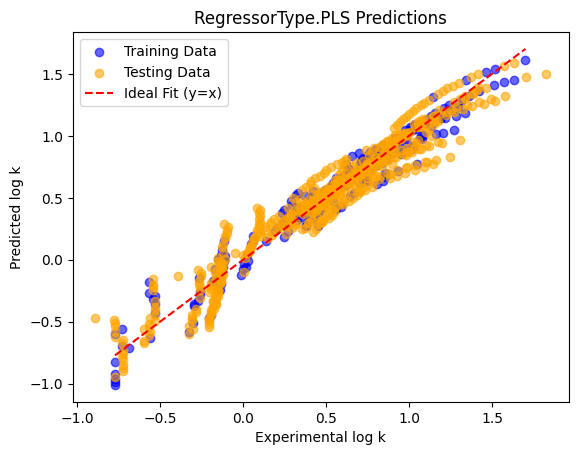

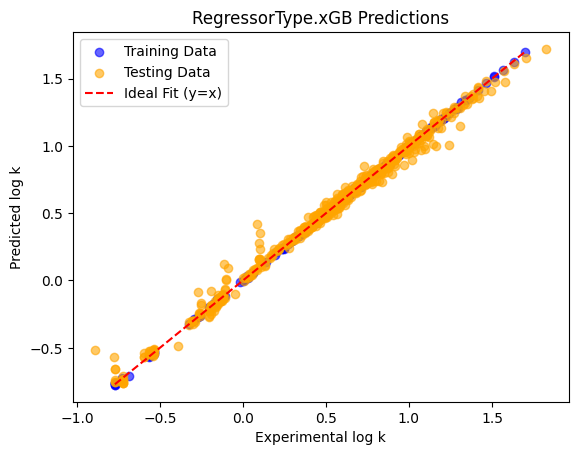

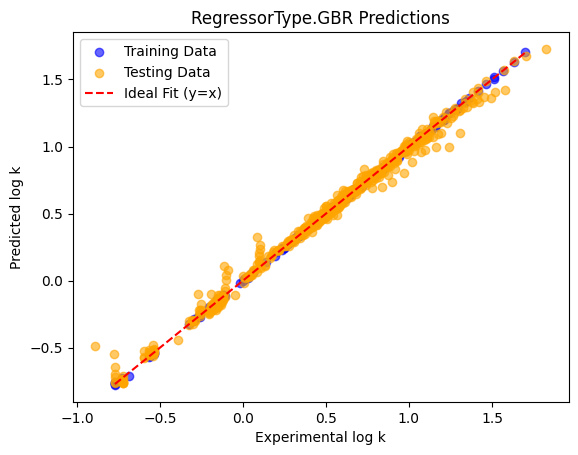

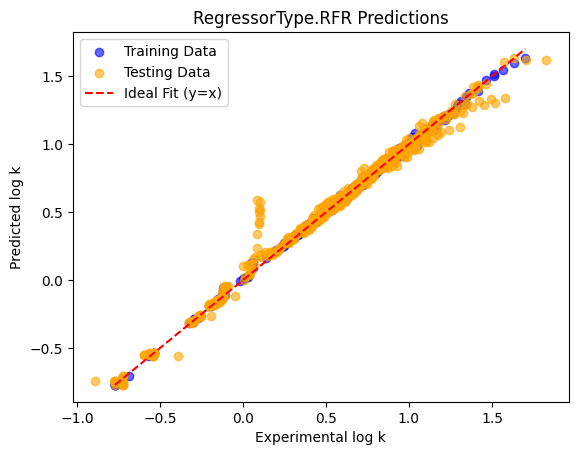

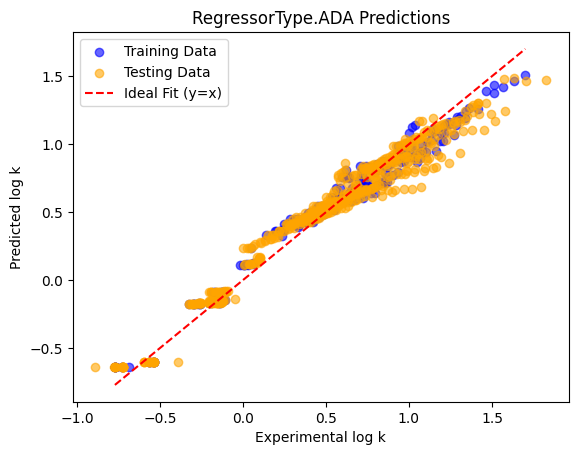

In [13]:
for regressor_type, qsrr_model in qsrr_models.items():
    
    fig, ax = plt.subplots()

    ax.set_title(f"{regressor_type} Predictions")
    ax.set_xlabel("Experimental log k")
    ax.set_ylabel("Predicted log k")

    # Training data scatter plot
    ax.scatter(
        qsrr_model.qsrr_train_data.y,
        qsrr_model.train_results.qsrr_predictions.y,
        label="Training Data",
        alpha=0.6,
        color="blue"
    )

    # Testing data scatter plot
    ax.scatter(
        qsrr_model.qsrr_test_data.y,
        qsrr_model.test_results.qsrr_predictions.y,
        label="Testing Data",
        alpha=0.6,
        color="orange"
    )

    # Diagonal reference line
    ax.plot(
        [min(qsrr_model.qsrr_train_data.y), max(qsrr_model.qsrr_train_data.y)],
        [min(qsrr_model.qsrr_train_data.y), max(qsrr_model.qsrr_train_data.y)],
        color="red", linestyle="--", label="Ideal Fit (y=x)"
    )

    ax.legend()
    plt.show()

## Prepare data & settings for iso2grad model

Below, we prepare settings & data for iso2grad modelling.

Settings:
* Integration step
* Number of Python processes to run Iso2Grad in parallel
* Verbosity if parallel calculation

Data needed:
* Molecular descriptors for iso2grad, all descriptors besides the eluent concentration (will be varied during the iso2grad numerical integration process)
* Void times of gradient calculations
* Gradient profiles, only linear profiles supported now
* Gradient retention times, optional data for validation

In [14]:
iso2grad_settings = single_train_config.iso2grad_config.iso2grad_settings
iso2grad_data = Iso2GradData(
    isocratic_model_predictors=data.molecular_descriptors_for_iso2grad,
    gradient_void_times=data.gradient_void_times,
    gradient_retention_profiles=data.gradient_profiles,
    gradient_retention_times=data.gradient_retention
)

In [15]:
data.molecular_descriptors_for_iso2grad.shape

(29, 54)

In [16]:
print(f"Iso2Grad settings: {iso2grad_settings.__dict__}")

Iso2Grad settings: {'integration_step': 0.01, 'n_jobs': 12, 'verbosity': 10}


## Train iso2grad models

Package *qsrr_ic* in the *QSRR_IC* repository implements singleton ModelRunner classes to run the model training.

Below, we loop over the `RegressorType` & the respective `QsrrModels`, then instantiate `QsrrIcModelRunner` that returns instance of `Iso2Grad`. `Iso2Grad` can also be invoked without using the `QsrrIcModelRunner` class.

In [17]:
iso2grad_models: Dict[RegressorType, RegressorType] = {}

for regressor_type, qsrr_model in qsrr_models.items():
    
    print(f"Training iso2grad model using {regressor_type.name} QSRR model")
    
    model_runner = QsrrIcModelRunner()

    model: Iso2Grad = model_runner.run(
        qsrr_model=qsrr_model,
        iso2grad_data=iso2grad_data,
        iso2grad_settings=iso2grad_settings
    )
    
    iso2grad_models[regressor_type] = model

Training iso2grad model using PLS QSRR model


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:   17.2s
[Parallel(n_jobs=12)]: Done   7 out of  27 | elapsed:   18.6s remaining:   53.3s
[Parallel(n_jobs=12)]: Done  10 out of  27 | elapsed:   19.4s remaining:   33.0s
[Parallel(n_jobs=12)]: Done  13 out of  27 | elapsed:   30.5s remaining:   32.9s
[Parallel(n_jobs=12)]: Done  16 out of  27 | elapsed:   30.7s remaining:   21.1s
[Parallel(n_jobs=12)]: Done  19 out of  27 | elapsed:   31.8s remaining:   13.3s
[Parallel(n_jobs=12)]: Done  22 out of  27 | elapsed:   32.1s remaining:    7.2s
[Parallel(n_jobs=12)]: Done  25 out of  27 | elapsed:   37.3s remaining:    2.9s
[Parallel(n_jobs=12)]: Done  27 out of  27 | elapsed:   38.7s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


Training iso2grad model using xGB QSRR model


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:   29.2s
[Parallel(n_jobs=12)]: Done   7 out of  27 | elapsed:   33.2s remaining:  1.6min
[Parallel(n_jobs=12)]: Done  10 out of  27 | elapsed:   39.2s remaining:  1.1min
[Parallel(n_jobs=12)]: Done  13 out of  27 | elapsed:   56.9s remaining:  1.0min
[Parallel(n_jobs=12)]: Done  16 out of  27 | elapsed:  1.0min remaining:   41.9s
[Parallel(n_jobs=12)]: Done  19 out of  27 | elapsed:  1.0min remaining:   26.1s
[Parallel(n_jobs=12)]: Done  22 out of  27 | elapsed:  1.1min remaining:   14.8s
[Parallel(n_jobs=12)]: Done  25 out of  27 | elapsed:  1.2min remaining:    5.8s
[Parallel(n_jobs=12)]: Done  27 out of  27 | elapsed:  1.3min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


Training iso2grad model using GBR QSRR model


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:   31.2s
[Parallel(n_jobs=12)]: Done   7 out of  27 | elapsed:   35.4s remaining:  1.7min
[Parallel(n_jobs=12)]: Done  10 out of  27 | elapsed:   38.0s remaining:  1.1min
[Parallel(n_jobs=12)]: Done  13 out of  27 | elapsed:   59.9s remaining:  1.1min
[Parallel(n_jobs=12)]: Done  16 out of  27 | elapsed:  1.0min remaining:   42.6s
[Parallel(n_jobs=12)]: Done  19 out of  27 | elapsed:  1.1min remaining:   27.0s
[Parallel(n_jobs=12)]: Done  22 out of  27 | elapsed:  1.1min remaining:   15.2s
[Parallel(n_jobs=12)]: Done  25 out of  27 | elapsed:  1.3min remaining:    6.0s
[Parallel(n_jobs=12)]: Done  27 out of  27 | elapsed:  1.4min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


Training iso2grad model using RFR QSRR model


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:  5.1min
[Parallel(n_jobs=12)]: Done   7 out of  27 | elapsed:  6.1min remaining: 17.4min
[Parallel(n_jobs=12)]: Done  10 out of  27 | elapsed:  6.6min remaining: 11.3min
[Parallel(n_jobs=12)]: Done  13 out of  27 | elapsed: 10.1min remaining: 10.9min
[Parallel(n_jobs=12)]: Done  16 out of  27 | elapsed: 10.7min remaining:  7.3min
[Parallel(n_jobs=12)]: Done  19 out of  27 | elapsed: 11.1min remaining:  4.7min
[Parallel(n_jobs=12)]: Done  22 out of  27 | elapsed: 11.5min remaining:  2.6min
[Parallel(n_jobs=12)]: Done  25 out of  27 | elapsed: 13.0min remaining:  1.0min
[Parallel(n_jobs=12)]: Done  27 out of  27 | elapsed: 13.9min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


Training iso2grad model using ADA QSRR model


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed: 41.4min
[Parallel(n_jobs=12)]: Done   7 out of  27 | elapsed: 45.7min remaining: 130.5min
[Parallel(n_jobs=12)]: Done  10 out of  27 | elapsed: 47.0min remaining: 80.0min
[Parallel(n_jobs=12)]: Done  13 out of  27 | elapsed: 81.8min remaining: 88.1min
[Parallel(n_jobs=12)]: Done  16 out of  27 | elapsed: 82.5min remaining: 56.7min
[Parallel(n_jobs=12)]: Done  19 out of  27 | elapsed: 87.1min remaining: 36.7min
[Parallel(n_jobs=12)]: Done  22 out of  27 | elapsed: 87.5min remaining: 19.9min
[Parallel(n_jobs=12)]: Done  25 out of  27 | elapsed: 107.4min remaining:  8.6min
[Parallel(n_jobs=12)]: Done  27 out of  27 | elapsed: 114.0min finished


In [18]:
iso2grad_models

{<RegressorType.PLS: 5>: <qsrr_ic.models.iso2grad.iso2grad.Iso2Grad at 0x27bc1f3d940>,
 <RegressorType.xGB: 1>: <qsrr_ic.models.iso2grad.iso2grad.Iso2Grad at 0x27bd8764160>,
 <RegressorType.GBR: 2>: <qsrr_ic.models.iso2grad.iso2grad.Iso2Grad at 0x27bd8755a90>,
 <RegressorType.RFR: 3>: <qsrr_ic.models.iso2grad.iso2grad.Iso2Grad at 0x27bd89d5460>,
 <RegressorType.ADA: 4>: <qsrr_ic.models.iso2grad.iso2grad.Iso2Grad at 0x27bd89eda30>}

In [19]:
iso2grad_metrics: List[DataFrame] = []

for regressor_type in iso2grad_models:
    iso2grad_metrics_: DataFrame = iso2grad_models[regressor_type].results.metrics.to_df()
    iso2grad_metrics_.columns = [regressor_type]
    iso2grad_metrics.append(iso2grad_metrics_)

print(f"Performance: ")
iso2grad_metrics_df: DataFrame = pd.concat(iso2grad_metrics, axis=1)
display(iso2grad_metrics_df)

Performance: 


,RegressorType.PLS,RegressorType.xGB,RegressorType.GBR,RegressorType.RFR,RegressorType.ADA
R2,0.894992,0.987786,0.986004,0.976667,0.837760
MAE,1.765089,0.550025,0.528943,0.752201,2.212034
MSE,6.589381,0.766427,0.878288,1.464197,10.180824
RMSE,2.566979,0.875458,0.937170,1.210040,3.190740
%MSE,5.939925,1.227248,0.841337,3.736499,5.120505
%RMSE,24.371962,11.078124,9.172444,19.330025,22.628532


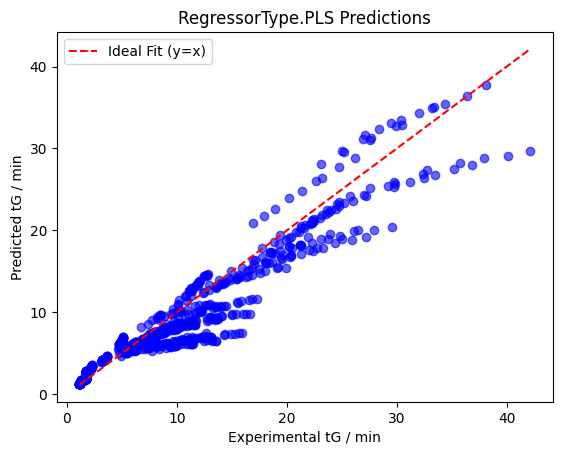

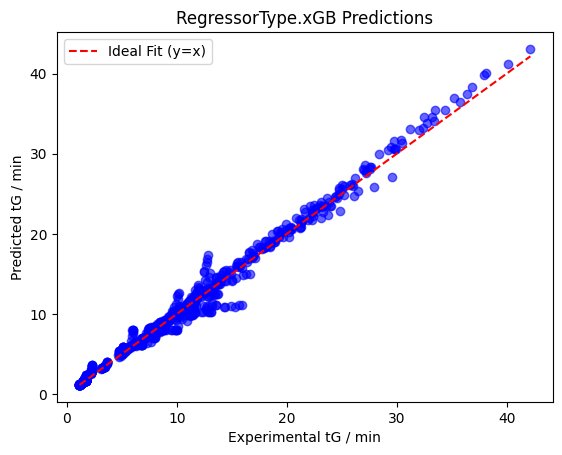

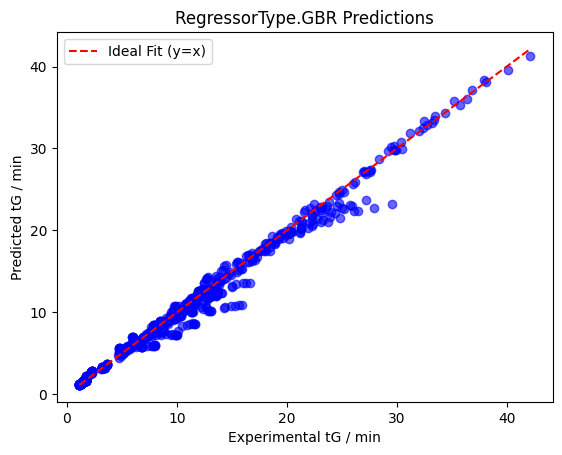

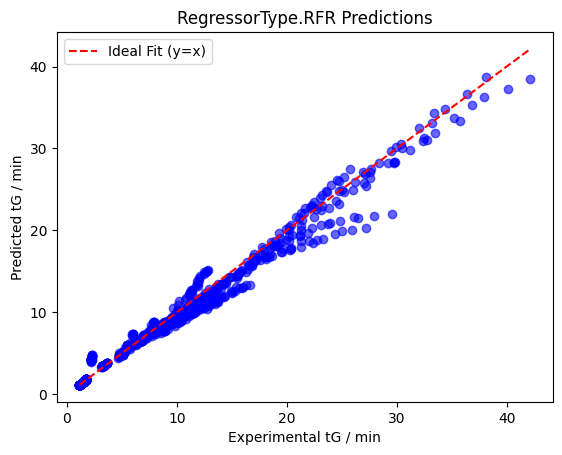

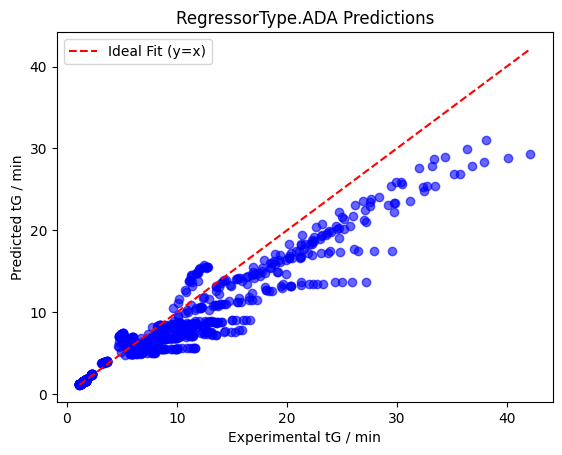

In [20]:
for regressor_type, iso2grad_model in iso2grad_models.items():
    
    fig, ax = plt.subplots()

    ax.set_title(f"{regressor_type} Predictions")
    ax.set_xlabel("Experimental tG / min")
    ax.set_ylabel("Predicted tG / min")

    # Training data scatter plot
    ax.scatter(
        iso2grad_model.results.metrics.qsrr_data.y,
        iso2grad_model.results.metrics.qsrr_predictions.y,
        alpha=0.6,
        color="blue"
    )

    # Diagonal reference line
    ax.plot(
        [min(iso2grad_model.results.metrics.qsrr_data.y), max(iso2grad_model.results.metrics.qsrr_data.y)],
        [min(iso2grad_model.results.metrics.qsrr_data.y), max(iso2grad_model.results.metrics.qsrr_data.y)],
        color="red", linestyle="--", label="Ideal Fit (y=x)"
    )

    ax.legend()
    plt.show()

## SRD Analysis

### SRD for QSRR models

In [21]:
# Calculate SRD for QSRR models
qsrr_srds: Dict[RegressorType, SumOfRankingDifferences] = {}

for regressor_type, qsrr_model in qsrr_models.items():
    qsrr_srds[regressor_type] = SumOfRankingDifferences(
        # Inputs = predictions
        inputs=np.vstack((qsrr_model.train_results.qsrr_predictions.y, qsrr_model.test_results.qsrr_predictions.y)).reshape(-1, 1),
        # Golden reference = exp retention data
        golden_reference=np.vstack((qsrr_model.qsrr_train_data.y, qsrr_model.qsrr_test_data.y)).reshape(-1, 1)
    )

normalized_srds = np.hstack([qsrr_srd.normalized_srds for qsrr_srd in qsrr_srds.values()])
normalized_random_srds = qsrr_srds[RegressorType.PLS].normalized_random_srds  # Can take from any of the SRD objects as the numbers are random

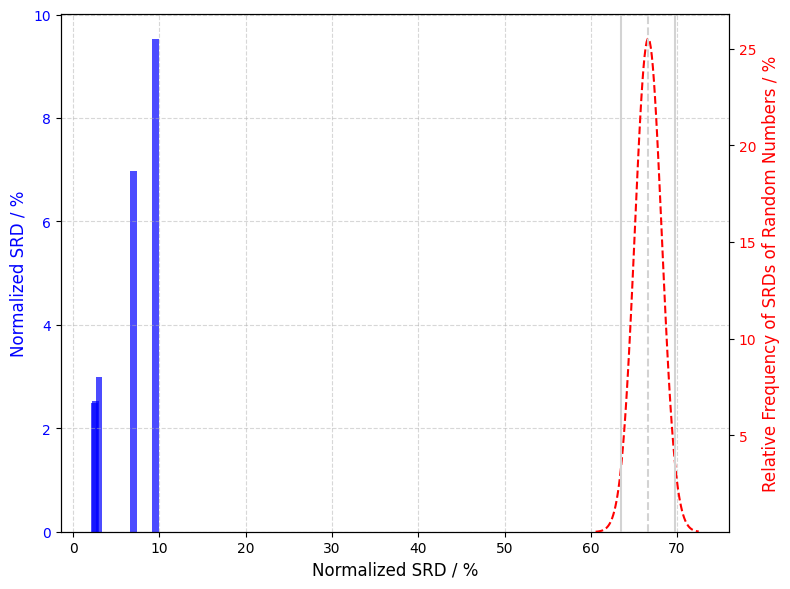

In [22]:
qsrr_srd_visualizer = SrdVisualizer(
    normalized_srds=normalized_srds,
    normalized_random_srds=normalized_random_srds
)
qsrr_srd_visualizer.visualize()

### SRD for iso2grad models

In [23]:
# Calculate SRD for iso2grad models
iso2grad_srds: Dict[RegressorType, SumOfRankingDifferences] = {}

for regressor_type, iso2grad_model in iso2grad_models.items():
    iso2grad_srds[regressor_type] = SumOfRankingDifferences(
        # Inputs = gradient time predictions
        inputs=iso2grad_model.results.gradient_retention_times,
        # Golden reference = exp gradient retention data
        golden_reference=iso2grad_data.gradient_retention_times
    )